In [6]:
import matplotlib.pylab as plt
get_ipython().magic('matplotlib inline')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [7]:
import pandas as pd
import matplotlib.pylab as plt


def get_main_metrics(ts_test, ts_predict, start_date, end_date,  col_test, col_predict):
    ts_mae = abs(ts_test[start_date:end_date][col_test] - ts_predict[start_date:end_date][col_predict])
    ts_mape = abs(ts_mae / ts_test[start_date:end_date][col_test])

    print("MAE = {}".format(ts_mae.mean()))

    print("MAPE = {}".format(ts_mape.mean()))
    
    print("Sum of data for the testing period: %s " % str(ts_test[start_date:end_date][col_test].sum()))
    print("Sum of predicted data for the testing period: %s " % str(ts_predict[start_date:end_date][col_predict].sum()))

In [11]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, maxlag=3, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    if dftest[0] > dftest[4]['5%']:
        print("Timeseries is NOT stationary")
    else:
        print("Timeseries is stationary")

    # Determing rolling statistics
    rolmean = timeseries.rolling(window=3, center=False).mean()
    rolstd = timeseries.rolling(window=3, center=False).std()  # Plot rolling statistics:
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()    

MAE = 0.2962171045183309
MAPE = 0.7617658860513379
Sum of data for the testing period: 16.85153 
Sum of predicted data for the testing period: 16.4575675545 


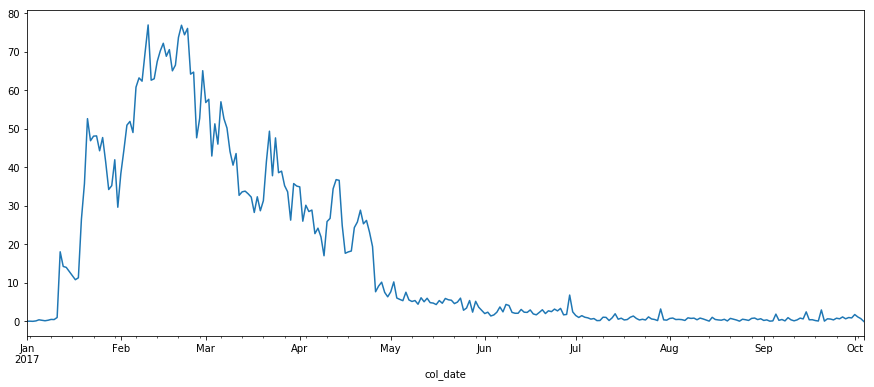

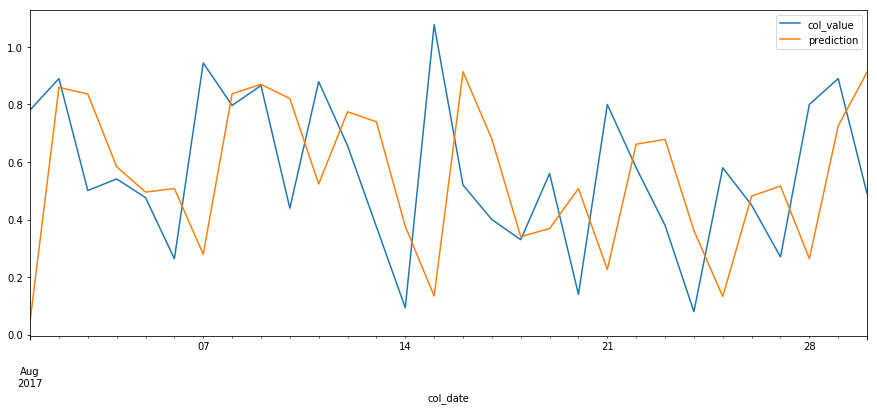

In [19]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

def parser(x):
    return pd.datetime.strptime(x[:10], "%Y-%m-%d")

ts = pd.read_csv("ts_revenue.csv", header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
ts.plot()

ts_train = ts[:"2017-08-01"]
ts_test = ts["2017-08-01":"2017-08-30"]

arima_model = ARIMA(ts, order=(1, 1, 1), freq='D').fit(disp=0)

ts_pred = arima_model.predict("2017-01-03", "2017-08-30", typ='levels')

ts_pred = ts_pred.to_frame()
ts_pred.columns = ["prediction"]
ts_pred.index.name = "col_date"

ts_test = ts_test.to_frame()
ts_test.columns = ["col_value"]
ts_test.index.name = "col_date"

ts_result = ts_test.join(ts_pred, how="left")

get_main_metrics(ts_result, ts_result, "2017-08-01", "2017-08-30", "col_value", "prediction")

ts_result.plot()

Results of Dickey-Fuller Test:
Test Statistic                  -1.372148
p-value                          0.595554
#Lags Used                       3.000000
Number of Observations Used    273.000000
Critical Value (1%)             -3.454533
Critical Value (5%)             -2.872186
Critical Value (10%)            -2.572443
dtype: float64
Timeseries is NOT stationary


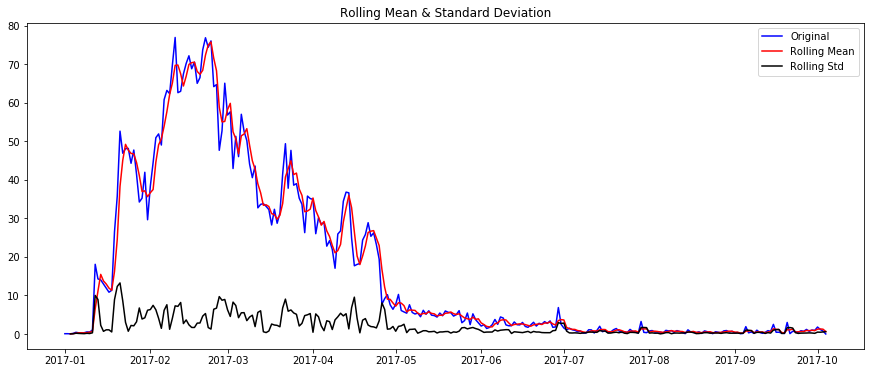

In [13]:
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                -1.031923e+01
p-value                        3.039791e-18
#Lags Used                     2.000000e+00
Number of Observations Used    2.730000e+02
Critical Value (1%)           -3.454533e+00
Critical Value (5%)           -2.872186e+00
Critical Value (10%)          -2.572443e+00
dtype: float64
Timeseries is stationary


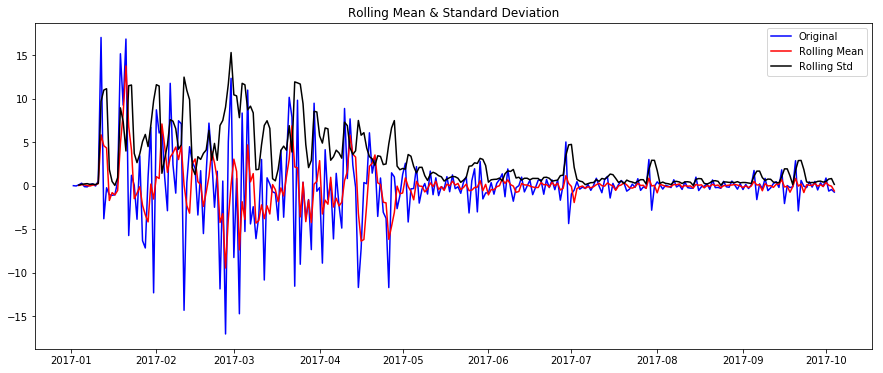

In [16]:
ts_revenue_diff = ts.diff(periods=1).dropna()

#ts_revenue_diff.plot()
test_stationarity(ts_revenue_diff)

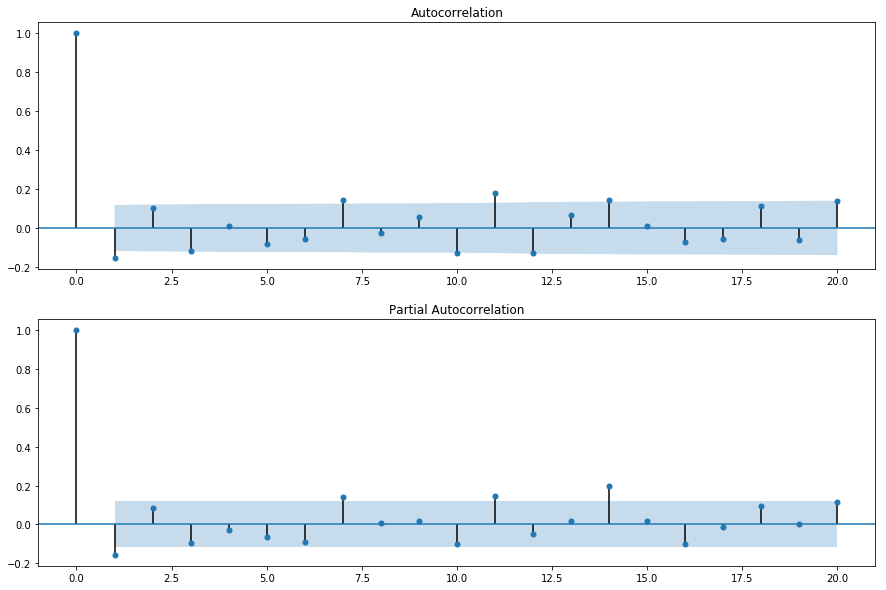

In [17]:
import statsmodels.api as sm
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_revenue_diff.values.squeeze(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_revenue_diff, lags=20, ax=ax2)